# Workspace \#9: ``model.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# The contents of model.py
dir(md)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'sk',
 'snr_routine']

In [4]:
dt.snrs_cut['G39.7-2.0'].__dict__

{'age': 54772.25575051661,
 'alpha': 0.7,
 'ang_size': 84.8528137423857,
 'b': -2.0,
 'distance': 4.9,
 'is_complete': False,
 'is_flux_certain': False,
 'is_spectral_certain': False,
 'is_type_certain': False,
 'l': 39.7,
 'name': 'G39.7-2.0',
 'no_dist': False,
 'no_flux': False,
 'radius': 60.47257332493333,
 'snu_at_1GHz': 85.0,
 'sr': 0.0004784858509023251}

In [6]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
# test_snr.__dict__ = {
#     'age': 35000.,
#     'alpha': 0.7,
#     'gamma': 1.8,
#     'ang_size': 84.8528137423857,
#     'sr': 0.0004784858509023251,
#     'distance': 1.8,
#     'no_dist': False,
#     'l': 39.7,
#     'b': -2.,
#     'name': 'W50',
#     'snu_at_1GHz': 310.0,
#     'no_flux': False,
#     'type': 'S'}

W28 = 'G6.4-0.1'
W50 = 'G39.7-2.0'

test_snr.__dict__ = {key:val for key, val in dt.snrs_dct[W50].__dict__.items()}

alpha = test_snr.get_spectral_index()

if alpha == None:
    alpha = 0.7
    test_snr.__dict__.update({'alpha':alpha})
    

# test_snr.__dict__.update({'age':35000, 'gamma': ap.gamma_from_alpha(alpha)})

# test_snr.__dict__.update({'age':38108.67943347, 'gamma': ap.gamma_from_alpha(alpha)})

test_snr.__dict__.update({'gamma': ap.gamma_from_alpha(alpha)})

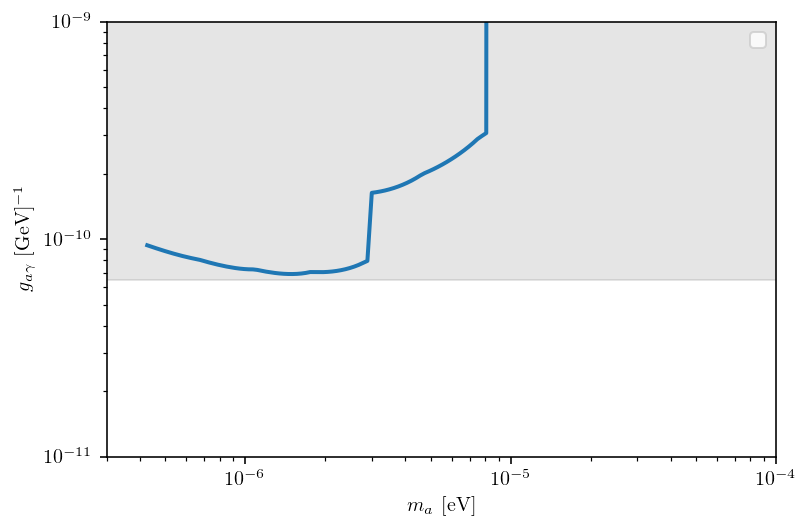

In [13]:
ma_arr = np.logspace(np.log10(1e-7), np.log10(2e-4), 200)
t_age_arr = np.logspace(3, 6, 7)
sig_noi_thres = 1.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

use_free = False

counter = 0
# best_snr = None
# best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for snr in [test_snr]:
    
    try:
        distance = snr.get_distance()

    except:
        continue
    
    t_age = snr.get_age()
        
    snu_echo_kwargs = {'tmin_default':None,
                           'Nt':100000, # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':100000, # for a fine enough array
                           't_extra_old':0.
                          }
    # data:
    data = {'deltaE_over_E':ct._deltaE_over_E_,
                'f_Delta':ct._f_Delta_,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0,
                'correlation_mode':'interferometry',
                'average':True
               }
        
    t_trans = 300.
    t_peak = 10.**(ct._mu_log10_tpk_) #* 10.
    
    lightcurve_params = {'t_peak':t_peak,
#                              'L_peak':L_peak,
                             't_age':t_age,
                             't_trans':t_trans,
                             'L_today':snr.get_luminosity(),
                             'use_free_expansion':use_free
                            }
        
    sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
    ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
    plt.plot(ma_arr, ga_arr, lw='2.', alpha=1.)
    counter += 1

#         if best_ga > ga_arr[0]:
#             best_snr = snr
#             best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-9)
plt.xlim(3e-7, 1e-4)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


# title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}"
# title = title_str.format(D=snr.distance,
#                          log10Lpk=np.log10(snr.Lpk), 
#                          log10tpk=np.log10(snr.tpk),
#                          ell=snr.l,
#                          b=snr.b,
#                          alpha=snr.alpha,
#                          sn=sig_noi_thres)

# plt.title(title)

# print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [17]:
verbose = 2
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans = 100.
# t_trans_over_t_peak = 30.
# t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in dt.snrs_age.items():
    
    t_age = snr.get_age()
    
    lightcurve_params = {'t_peak':tpk,
                         't_trans':t_trans,
                         't_age':t_age}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':ct._deltaE_over_E_,
            'f_Delta':ct._f_Delta_,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'correlation_mode':'interferometry',
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True,
                                   verbose=verbose)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    L0 = snr.get_luminosity() # [cgs]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
SNR size=3.2e-06. Value will be respected.
signal power:5.91499551318e-19
noise power:1.9003454858e-17
s/n: 0.0311258955667

SNR size=3.3e-07. Value will be respected.
signal power:6.53965952833e-19
noise power:1.38545675108e-17
s/n: 0.0472021917914

SNR size=1.1e-06. Value will be respected.
signal power:4.06967603095e-19
noise power:1.43066404288e-17
s/n: 0.0284460635688

SNR size=6.4e-06. Value will be respected.
signal power:4.33150217425e-19
noise power:2.82351062765e-17
s/n: 0.0153408389253

SNR size=4.1e-04. Value will be respected.
signal power:8.75847134868e-17
noise power:1.3045684341e-16
s/n: 0.67136925283

SNR size=1.9e-05. Value will be respected.
signal power:1.62623809994e-18
noise power:3.72964623505e-17
s/n: 0.0436030121211

SNR size=4.3e-06. Value will be respected.
signal power:7.2490637281e-19
noise power:1.98837014008e-17
s/n: 0.0364573153759

SNR size=6.1e-05. Value will be r